##### Bastien AVRILLON et Guillaume GIESSNER (Groupe n°4)

# <center>Mini-projet 4 d'Optimisation - RESTAURATION D'IMAGES</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math

## 1 - Étude du problème d'optimisation

#### Question 1 -

Les variables de décisions sont les $N = n \times m$ pixel de l'images qui forment donc un vecteur $z \in \mathbb{R}^{n \times m}$. Par commodité, on indice ces variables par leur position dans l'image, en voyant $z$ comme une matrice de $\mathcal{M}_{n \times m}(\mathbb{R})$.

Le problème de restauration d’image consiste à minimiser la fonction coût suivante :

$\begin{aligned}
f \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
z \mapsto f(z) & = \dfrac{1}{2} \| z - u_b \|_2^2 + \sum_{i,j} \| \nabla z(i,j) \|_2^2 \\
                &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \dfrac{1}{2} (z(i,j) - u_b(i,j))^2 \\
                &+ \sum_{1 \leq j < m} \left( z(n, j+1) - z(n, j) \right)^2 \\ 
                &+ \sum_{1 \leq i < n} \left( z(i+1, m) - z(i, m) \right)^2 \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left( z(i+1, j) - z(i, j) \right)^2 + \left( z(i, j+1) - z(i, j) \right)^2
\end{aligned}$

On a effectivement  $\|\nabla u(i,j)\|_2^2 = \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 $, donc :

$ \begin{aligned}
\sum_{i,j} \| \nabla u(i,j) \|_2^2 &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 \\
&= \sum_{1 \leq j < n} \left( u(n, j+1) - u(n, j) \right)^2 + 
    \sum_{1 \leq i < n} \left( u(i+1, n) - u(i, n) \right)^2
    \sum_{1 \leq i < n \; , \; 1 \leq j < m} \left( u(i+1, j) - u(i, j) \right)^2 + \left( u(i, j+1) - u(i, j) \right)^2 \end{aligned}$

La contrainte imposée dans la minimisation est définie par :

$\begin{aligned}
c \colon \mathbb{R}^{2n \times m} &\to \mathbb{R}^{2n \times m}  \\
z &\mapsto c(z) = \begin{cases} 
-z(i,j) & \text{si } 1 \leq i \leq n, \\ 
z(i,j) - 1 & \text{si } n + 1 \leq i \leq 2n. 
\end{cases} 
\end{aligned}$


De cette manière, le problème de minimisation devient : $\min\limits_{z \in \mathbb{R}^{n \times m},\ c(z) \leq 0} f(z)$


#### Question 2 -

$ u \mapsto \frac{1}{2} \| u - u_b \|_2^2 $ est une fonction quadratique de matrice héssienne $I_{nm}$ (qui est symétrique positive) donc convexe, 

$ u \mapsto \sum_{i,j} \| \nabla u(i,j) \|_2^2 $ est également convexe, car comme détaillé par le calcul à la question précédente, elle s'écrit comme 3 sommes de termes de la forme $ u \mapsto (u(k,l) - u(p,q))^2 $, qui sont eux-même convexe par composition préservant la convexité de l'application linéaire $ u \mapsto u(k,l) - u(p,q) $ avec la fonction carré qui est convexe sur $\mathbb{R}$.

Ainsi, $f$ est convexe, comme somme de ceux fonctions convexes.

La différentiabilité de cette fonction $f$ provient du fait qu'elle est une fonction polynomiale (en les coordonnées de la base canonique de $\mathbb{R}^{n \times m}$),comme détaillé par le calcul à la question précédente.

#### Question 3 -

/ Guillaume /

## 2 - Résolution numérique

#### Question 4 -

In [2]:
from scipy.ndimage import gaussian_filter

def grad_img(u):                                    #Gradient d'une image
    grad_x = np.zeros_like(u)
    grad_y = np.zeros_like(u)
    grad_x[:-1, :] = u[1:, :] - u[:-1, :]
    grad_y[:, :-1] = u[:, 1:] - u[:, :-1]
    grad_im = np.stack((grad_x, grad_y), axis=-1)
    return grad_im

def divergence(v):                              #Divergence d'une fonction
    div = np.zeros_like(v)[:,:,0]
    div[1:-1,:] += v[1:-1,:,0] - v[:-2, :,0]
    div[:, 1:-1] += v[:,1:-1,1] - v[:,:-2,1]
    div[0,:] += v[0,:,0]
    div[:,0] += v[:,0,1]
    div[-1,:] -= v[-2,:,0]
    div[:,-1] -= v[:,-2,1]
    return div

def laplacien(u):                               #Laplacien d'une image
    grad_im = grad_img(u)
    return divergence(grad_im)

In [3]:
#L'image d'origine est en RGB, on l'importe en noir et blanc avec 1 canal :
img_noise = plt.imread('robot_noise.jpg')[...,0]          
img_no_noise = plt.imread('robot_no_noise.jpg')[...,0]

#L'importation code les pixels sur des entiers de 8bits, on veut des flotants de 32bits :
img_noise = img_noise.astype(np.float32) / 255.0
img_no_noise = img_no_noise.astype(np.float32) / 255.0

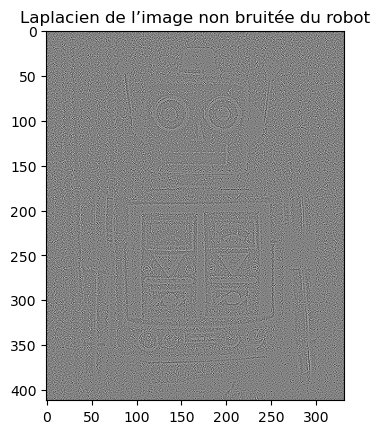

In [4]:
plt.imshow(laplacien(img_noise),cmap='gray')
plt.title("Laplacien de l’image non bruitée du robot")
plt.show()

In [77]:
grad_f_xk = grad_f(img_noise)
np.linalg.norm(grad_f_xk.reshape(-1),1)

186072.8

#### Question 5 -

In [6]:
def optim_gradient_fixed_step(grad_fun, x0, l, max_iter = 100000, epsilon_grad_fun = 1e-5):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    nb_iterations = 0
    while ((k<max_iter) and (np.linalg.norm(grad_f_xk.reshape(-1),1)>epsilon_grad_fun)):
        pk = -grad_f_xk
        xk = xk + l*pk
        grad_f_xk = grad_fun(xk)
        k = k + 1
        nb_iterations += 1
    return xk,nb_iterations

def grad_f(u):
    res = u -img_noise -2*laplacien(u) 
    return res

u_optim_fixed_step,nb_iterations = optim_gradient_fixed_step(grad_f, img_noise, 0.05, max_iter = 100000, epsilon_grad_fun = 1e-5)
print(nb_iterations)

100000


0.028647592


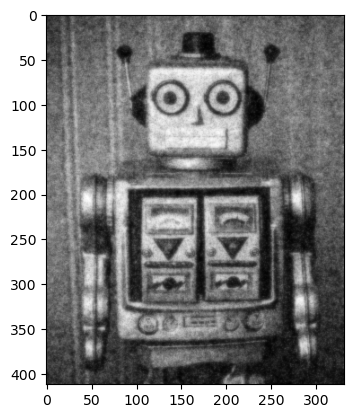

In [7]:
plt.imshow(u_optim_fixed_step, cmap='gray')

norme = np.linalg.norm(grad_f(u_optim_fixed_step).reshape(-1),1)
print(norme)

Commenter......

#### Question 6 -

In [11]:
def RMSE(u):
    difference =  img_no_noise - u 
    numerateur = np.linalg.norm(difference.reshape(-1),2)**2
    denominateur = math.prod(u.shape)
    res = (numerateur/denominateur)**0.5
    return res

print(f"RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : {RMSE(u_optim_fixed_step)}")
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")

RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : 0.09647673883877508
RMSE pour l'image bruitée d'origine : 0.1852844596946583


#### Question 7 -

In [19]:
def f(u):
    difference =  u -img_noise
    terme_1 = 0.5*np.linalg.norm(difference.reshape(-1),2)**2
    terme_2 = np.linalg.norm(grad_img(u).ravel(),2)**2
    res = terme_1 + terme_2
    return res

In [ ]:
n,m = img_noise.shape

def f_scipy(u):
    u_mat = u.reshape(n,m)
    return f(u_mat)

u0 = img_noise.ravel()
bounds = [(0, 1)] * (n*m)

u_vect_minimisation_scipy = optimize.minimize(f_scipy,u0,method='L-BFGS-B',bounds=bounds).x     #Plus performant sue BFGS en grande dimension

u_minimisation_scipy = u_vect_minimisation_scipy.reshape(n,m)

MemoryError: Unable to allocate 139. GiB for an array with shape (136784, 136784) and data type float64